In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import cv2, random
from pathlib import Path
import dataclasses

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


from warnings import filterwarnings
filterwarnings("ignore")

import os
import sys
sys.path.append(os.path.join(str(os.path.abspath('')), "..", "..", "..", ".."))
from src.detector.get_dicts import get_COVID19_data_dicts
from src.detector.custom_trainer import MyTrainer
from src.detector.flags import Flags
from src.detector.save_yaml import save_yaml


setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
flags_dict = {
    "debug": False,
    "fold": 1,
    "outdir": "results/", 
    "root_imgdir": PATH_TO_IMAGES, # !!! DEFINE "PATH_TO_IMAGES" on your local machine,
    "path_to_meta_df": "../../cross_validation_scheme/modified_detectron_data/meta_df.csv",
    "path_to_train_df": "../../cross_validation_scheme/modified_detectron_data/detectron_prepared_df.csv",
    "use_cache": False,
    "img_size": "1024x1024",
    "cv_scheme": "skf",
    "use_negative": False,
    "binary_task": True,
    
    "iter": 4000,
    "roi_batch_size_per_image": 256,
    "eval_period": 1000,
#     "lr_scheduler_name": "WarmupMultiStepLR",
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.0025,
    "num_workers": 4,
    "ims_per_batch": 8,
    
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "HueSaturationValue": {"hue_shift_limit": 10, "sat_shift_limit": 10, "val_shift_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CLAHE": {"clip_limit": (1,4), "p": 0.5},
        "GaussianBlur": {"p": 0.5}
    },
}

In [3]:
flags = Flags().update(flags_dict)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

In [4]:
thing_classes = [
    "opacity"
]

In [5]:
DatasetCatalog.register(
    "COVID19_data_train",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='train',
                                    fold=flags.fold,
                                  ),
)
MetadataCatalog.get("COVID19_data_train").set(thing_classes=thing_classes)


DatasetCatalog.register(
    "COVID19_data_valid",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='val',
                                    fold=flags.fold,
                                  ),
    )
MetadataCatalog.get("COVID19_data_valid").set(thing_classes=thing_classes)

dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")

dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg


  2%|▏         | 79/4834 [00:00<00:06, 785.74it/s]

image shape: (1024, 1024, 3)


  0%|          | 0/1196 [00:00<?, ?it/s]

Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1196/1196 [00:01<00:00, 803.25it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl


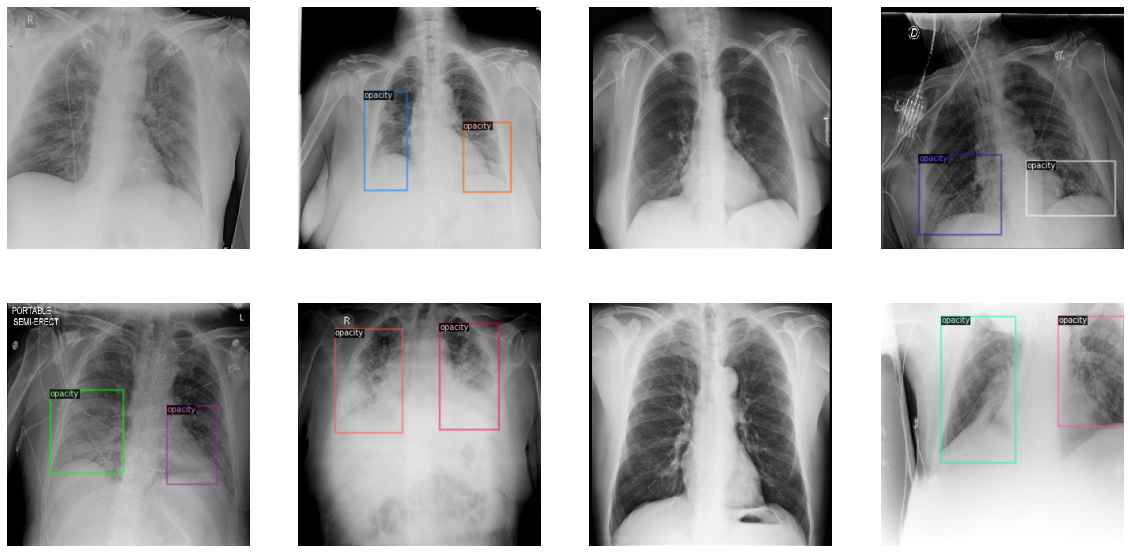

In [6]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [7]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = flags.outdir
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("COVID19_data_train",)
cfg.DATASETS.TEST = ("COVID19_data_valid",)
cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Loading config /home/greylord/siim_covid/covid_env/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> results/


In [8]:
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/01 14:40:48 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

  2%|▏         | 80/4834 [00:00<00:05, 793.11it/s]

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-10, 10), sat_shift_limit=(-10, 10), val_shift_limit=(-10, 10)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
  GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=(0, 0)),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating dat

100%|██████████| 4834/4834 [00:05<00:00, 809.73it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 14:40:54 d2.data.build]: Removed 1389 images with no usable annotations. 3445 images left.
[08/01 14:40:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 6297         |
|            |              |
[08/01 14:40:54 d2.data.build]: Using training sampler TrainingSampler
[08/01 14:40:54 d2.data.common]: Serializing 3445 elements to byte tensors and concatenating them all ...
[08/01 14:40:54 d2.data.common]: Serialized dataset takes 1.21 MiB


  0%|          | 0/1196 [00:00<?, ?it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1196/1196 [00:01<00:00, 792.32it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 14:40:56 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 1555         |
|            |              |
[08/01 14:40:56 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/01 14:40:56 d2.data.common]: Serialized dataset takes 0.36 MiB
[08/01 14:40:57 d2.engine.train_loop]: Starting training from iteration 0
[08/01 14:41:20 d2.utils.events]:  eta: 1:14:09  iter: 19  total_loss: 2.037  loss_cls: 1.208  loss_box_reg: 0.8135  time: 1.1160  data_time: 0.0473  lr: 4.2996e-05  max_mem: 18669M
[08/01 14:41:42 d2.utils.events]:  eta: 1:12:25  iter: 39  total_loss: 1.113  loss_cls: 0.5437  loss_box_reg: 0.5877  time: 1.1031  data_time: 0.0150  lr: 8.5624e-05  max_mem: 18669M
[08/01 14:42:05 d2.utils.events]:  eta: 1:12:33  iter: 59  total_l

[08/01 14:55:35 d2.utils.events]:  eta: 0:55:48  iter: 819  total_loss: 0.7623  loss_cls: 0.3229  loss_box_reg: 0.4451  time: 1.0688  data_time: 0.0159  lr: 0.0017481  max_mem: 18669M
[08/01 14:55:56 d2.utils.events]:  eta: 0:55:27  iter: 839  total_loss: 0.8581  loss_cls: 0.3992  loss_box_reg: 0.4735  time: 1.0685  data_time: 0.0160  lr: 0.0017907  max_mem: 18669M
[08/01 14:56:17 d2.utils.events]:  eta: 0:55:06  iter: 859  total_loss: 0.749  loss_cls: 0.3314  loss_box_reg: 0.4278  time: 1.0681  data_time: 0.0154  lr: 0.0018334  max_mem: 18669M
[08/01 14:56:38 d2.utils.events]:  eta: 0:54:45  iter: 879  total_loss: 0.8133  loss_cls: 0.3342  loss_box_reg: 0.4599  time: 1.0678  data_time: 0.0164  lr: 0.001876  max_mem: 18669M
[08/01 14:56:59 d2.utils.events]:  eta: 0:54:24  iter: 899  total_loss: 0.7723  loss_cls: 0.3339  loss_box_reg: 0.4429  time: 1.0675  data_time: 0.0159  lr: 0.0019186  max_mem: 18669M
[08/01 14:57:20 d2.utils.events]:  eta: 0:54:03  iter: 919  total_loss: 0.7105  lo

  7%|▋         | 78/1196 [00:00<00:01, 762.79it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1196/1196 [00:01<00:00, 798.66it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 14:58:46 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/01 14:58:46 d2.data.common]: Serialized dataset takes 0.36 MiB
[08/01 14:58:46 d2.evaluation.coco_evaluation]: 'COVID19_data_valid' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[08/01 14:58:46 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_valid' to COCO format ...)


  7%|▋         | 81/1196 [00:00<00:01, 802.15it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1196/1196 [00:01<00:00, 803.76it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 14:58:48 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[08/01 14:58:48 d2.data.datasets.coco]: Conversion finished, #images: 1196, #annotations: 1555
[08/01 14:58:48 d2.data.datasets.coco]: Caching COCO format annotations at 'results/inference/COVID19_data_valid_coco_format.json' ...
[08/01 14:58:48 d2.evaluation.evaluator]: Start inference on 1196 images
[08/01 14:58:49 d2.evaluation.evaluator]: Inference done 11/1196. 0.0531 s / img. ETA=0:01:04
[08/01 14:58:54 d2.evaluation.evaluator]: Inference done 102/1196. 0.0533 s / img. ETA=0:01:00
[08/01 14:58:59 d2.evaluation.evaluator]: Inference done 193/1196. 0.0533 s / img. ETA=0:00:55
[08/01 14:59:04 d2.evaluation.evaluator]: Inference done 284/1196. 0.0533 s / img. ETA=0:00:50
[08/01 14:59:09 d2.evaluation.evaluator]: Inference done 373/1196. 0.0534 s / img. ETA=0:00:45
[08/01 14:59:14 d2.evaluation.evaluator]: Inference done 464/1196. 0.0534 s / img. ETA=0:00:40
[08/01 14:59:19 d2.evaluation.evaluator]: Inference done 555/1196. 0.0534 s / img. ETA=0:00:35
[08/01 14:59:24 d2.evaluation.eva

[08/01 15:07:09 d2.utils.events]:  eta: 0:46:39  iter: 1339  total_loss: 0.7272  loss_cls: 0.3096  loss_box_reg: 0.4233  validation_loss: 0.7668  time: 1.0626  data_time: 0.0159  lr: 0.0018702  max_mem: 18669M
[08/01 15:07:30 d2.utils.events]:  eta: 0:46:18  iter: 1359  total_loss: 0.7595  loss_cls: 0.3364  loss_box_reg: 0.4454  validation_loss: 0.7668  time: 1.0625  data_time: 0.0162  lr: 0.0018531  max_mem: 18669M
[08/01 15:07:51 d2.utils.events]:  eta: 0:45:57  iter: 1379  total_loss: 0.7313  loss_cls: 0.2948  loss_box_reg: 0.4348  validation_loss: 0.7668  time: 1.0623  data_time: 0.0165  lr: 0.0018358  max_mem: 18669M
[08/01 15:08:12 d2.utils.events]:  eta: 0:45:36  iter: 1399  total_loss: 0.7392  loss_cls: 0.3061  loss_box_reg: 0.4347  validation_loss: 0.7668  time: 1.0621  data_time: 0.0162  lr: 0.0018184  max_mem: 18669M
[08/01 15:08:33 d2.utils.events]:  eta: 0:45:15  iter: 1419  total_loss: 0.7203  loss_cls: 0.2931  loss_box_reg: 0.4245  validation_loss: 0.7668  time: 1.0620  

  7%|▋         | 82/1196 [00:00<00:01, 815.50it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1196/1196 [00:01<00:00, 827.11it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 15:18:45 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/01 15:18:45 d2.data.common]: Serialized dataset takes 0.36 MiB
[08/01 15:18:45 d2.evaluation.evaluator]: Start inference on 1196 images


[08/01 15:18:45 d2.evaluation.evaluator]: Inference done 11/1196. 0.0533 s / img. ETA=0:01:04
[08/01 15:18:50 d2.evaluation.evaluator]: Inference done 102/1196. 0.0533 s / img. ETA=0:01:00
[08/01 15:18:55 d2.evaluation.evaluator]: Inference done 193/1196. 0.0533 s / img. ETA=0:00:55
[08/01 15:19:00 d2.evaluation.evaluator]: Inference done 284/1196. 0.0533 s / img. ETA=0:00:50
[08/01 15:19:05 d2.evaluation.evaluator]: Inference done 375/1196. 0.0533 s / img. ETA=0:00:45
[08/01 15:19:10 d2.evaluation.evaluator]: Inference done 466/1196. 0.0533 s / img. ETA=0:00:40
[08/01 15:19:15 d2.evaluation.evaluator]: Inference done 557/1196. 0.0533 s / img. ETA=0:00:35
[08/01 15:19:20 d2.evaluation.evaluator]: Inference done 648/1196. 0.0533 s / img. ETA=0:00:30
[08/01 15:19:26 d2.evaluation.evaluator]: Inference done 739/1196. 0.0533 s / img. ETA=0:00:25
[08/01 15:19:31 d2.evaluation.evaluator]: Inference done 828/1196. 0.0533 s / img. ETA=0:00:20
[08/01 15:19:36 d2.evaluation.evaluator]: Inference

[08/01 15:27:47 d2.utils.events]:  eta: 0:28:22  iter: 2379  total_loss: 0.7166  loss_cls: 0.2962  loss_box_reg: 0.3883  validation_loss: 0.7548  time: 1.0578  data_time: 0.0164  lr: 0.00088339  max_mem: 18669M
[08/01 15:28:08 d2.utils.events]:  eta: 0:28:01  iter: 2399  total_loss: 0.7296  loss_cls: 0.2879  loss_box_reg: 0.4309  validation_loss: 0.7548  time: 1.0578  data_time: 0.0164  lr: 0.00086466  max_mem: 18669M
[08/01 15:28:29 d2.utils.events]:  eta: 0:27:40  iter: 2419  total_loss: 0.7175  loss_cls: 0.2972  loss_box_reg: 0.4125  validation_loss: 0.7548  time: 1.0577  data_time: 0.0160  lr: 0.00084603  max_mem: 18669M
[08/01 15:28:50 d2.utils.events]:  eta: 0:27:19  iter: 2439  total_loss: 0.7025  loss_cls: 0.2884  loss_box_reg: 0.4263  validation_loss: 0.7548  time: 1.0577  data_time: 0.0163  lr: 0.0008275  max_mem: 18669M
[08/01 15:29:11 d2.utils.events]:  eta: 0:26:58  iter: 2459  total_loss: 0.6987  loss_cls: 0.2885  loss_box_reg: 0.3924  validation_loss: 0.7548  time: 1.057

  7%|▋         | 82/1196 [00:00<00:01, 813.97it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1196/1196 [00:01<00:00, 825.17it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 15:38:49 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/01 15:38:49 d2.data.common]: Serialized dataset takes 0.36 MiB
[08/01 15:38:49 d2.evaluation.evaluator]: Start inference on 1196 images


[08/01 15:38:50 d2.evaluation.evaluator]: Inference done 11/1196. 0.0533 s / img. ETA=0:01:04
[08/01 15:38:55 d2.evaluation.evaluator]: Inference done 102/1196. 0.0535 s / img. ETA=0:01:00
[08/01 15:39:00 d2.evaluation.evaluator]: Inference done 193/1196. 0.0535 s / img. ETA=0:00:55
[08/01 15:39:05 d2.evaluation.evaluator]: Inference done 283/1196. 0.0536 s / img. ETA=0:00:50
[08/01 15:39:10 d2.evaluation.evaluator]: Inference done 374/1196. 0.0536 s / img. ETA=0:00:45
[08/01 15:39:15 d2.evaluation.evaluator]: Inference done 464/1196. 0.0536 s / img. ETA=0:00:40
[08/01 15:39:20 d2.evaluation.evaluator]: Inference done 553/1196. 0.0537 s / img. ETA=0:00:35
[08/01 15:39:25 d2.evaluation.evaluator]: Inference done 643/1196. 0.0537 s / img. ETA=0:00:30
[08/01 15:39:30 d2.evaluation.evaluator]: Inference done 733/1196. 0.0537 s / img. ETA=0:00:25
[08/01 15:39:35 d2.evaluation.evaluator]: Inference done 823/1196. 0.0537 s / img. ETA=0:00:20
[08/01 15:39:40 d2.evaluation.evaluator]: Inference

[08/01 15:47:33 d2.utils.events]:  eta: 0:11:16  iter: 3359  total_loss: 0.7263  loss_cls: 0.2892  loss_box_reg: 0.4162  validation_loss: 0.7427  time: 1.0594  data_time: 0.0162  lr: 0.00015509  max_mem: 18669M
[08/01 15:47:55 d2.utils.events]:  eta: 0:10:55  iter: 3379  total_loss: 0.69  loss_cls: 0.2841  loss_box_reg: 0.3939  validation_loss: 0.7427  time: 1.0594  data_time: 0.0166  lr: 0.00014575  max_mem: 18669M
[08/01 15:48:16 d2.utils.events]:  eta: 0:10:33  iter: 3399  total_loss: 0.6274  loss_cls: 0.235  loss_box_reg: 0.3751  validation_loss: 0.7427  time: 1.0594  data_time: 0.0161  lr: 0.00013669  max_mem: 18669M
[08/01 15:48:37 d2.utils.events]:  eta: 0:10:12  iter: 3419  total_loss: 0.6461  loss_cls: 0.2573  loss_box_reg: 0.3894  validation_loss: 0.7427  time: 1.0594  data_time: 0.0168  lr: 0.0001279  max_mem: 18669M
[08/01 15:48:58 d2.utils.events]:  eta: 0:09:51  iter: 3439  total_loss: 0.6163  loss_cls: 0.2532  loss_box_reg: 0.3725  validation_loss: 0.7427  time: 1.0594  

  7%|▋         | 79/1196 [00:00<00:01, 783.71it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1196/1196 [00:01<00:00, 791.79it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 15:59:03 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/01 15:59:03 d2.data.common]: Serialized dataset takes 0.36 MiB
[08/01 15:59:03 d2.evaluation.evaluator]: Start inference on 1196 images
[08/01 15:59:04 d2.evaluation.evaluator]: Inference done 11/1196. 0.0613 s / img. ETA=0:01:14
[08/01 15:59:09 d2.evaluation.evaluator]: Inference done 94/1196. 0.0590 s / img. ETA=0:01:07
[08/01 15:59:14 d2.evaluation.evaluator]: Inference done 185/1196. 0.0563 s / img. ETA=0:00:58
[08/01 15:59:19 d2.evaluation.evaluator]: Inference done 276/1196. 0.0554 s / img. ETA=0:00:52
[08/01 15:59:24 d2.evaluation.evaluator]: Inference done 367/1196. 0.0549 s / img. ETA=0:00:47
[08/01 15:59:29 d2.evaluation.evaluator]: Inference done 457/1196. 0.0547 s / img. ETA=0:00:41
[08/01 15:59:34 d2.evaluation.evaluator]: Inference done 547/1196.

  7%|▋         | 82/1196 [00:00<00:01, 811.02it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1196/1196 [00:01<00:00, 806.77it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 16:01:30 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/01 16:01:30 d2.data.common]: Serialized dataset takes 0.36 MiB


[08/01 16:01:30 d2.evaluation.evaluator]: Start inference on 1196 images
[08/01 16:01:31 d2.evaluation.evaluator]: Inference done 11/1196. 0.0536 s / img. ETA=0:01:05
[08/01 16:01:36 d2.evaluation.evaluator]: Inference done 101/1196. 0.0537 s / img. ETA=0:01:00
[08/01 16:01:41 d2.evaluation.evaluator]: Inference done 184/1196. 0.0559 s / img. ETA=0:00:58
[08/01 16:01:46 d2.evaluation.evaluator]: Inference done 270/1196. 0.0561 s / img. ETA=0:00:53
[08/01 16:01:51 d2.evaluation.evaluator]: Inference done 361/1196. 0.0555 s / img. ETA=0:00:47
[08/01 16:01:56 d2.evaluation.evaluator]: Inference done 451/1196. 0.0551 s / img. ETA=0:00:42
[08/01 16:02:01 d2.evaluation.evaluator]: Inference done 541/1196. 0.0548 s / img. ETA=0:00:37
[08/01 16:02:06 d2.evaluation.evaluator]: Inference done 631/1196. 0.0546 s / img. ETA=0:00:32
[08/01 16:02:11 d2.evaluation.evaluator]: Inference done 721/1196. 0.0545 s / img. ETA=0:00:26
[08/01 16:02:16 d2.evaluation.evaluator]: Inference done 811/1196. 0.0544

In [9]:
evaluator = COCOEvaluator("COVID19_data_train", cfg, False, output_dir="./results")
val_loader = build_detection_test_loader(cfg, "COVID19_data_train")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [08/01 16:02:38 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/01 16:02:38 d2.evaluation.coco_evaluation]: 'COVID19_data_train' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[08/01 16:02:38 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_train' to COCO format ...)


  0%|          | 0/4834 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4834/4834 [00:06<00:00, 791.78it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 16:02:45 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/01 16:02:45 d2.data.datasets.coco]: Conversion finished, #images: 4834, #annotations: 6297
[08/01 16:02:45 d2.data.datasets.coco]: Caching COCO format annotations at './results/COVID19_data_train_coco_format.json' ...


  0%|          | 0/4834 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4834/4834 [00:06<00:00, 802.31it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_1_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 16:02:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/01 16:02:52 d2.data.common]: Serializing 4834 elements to byte tensors and concatenating them all ...
[08/01 16:02:52 d2.data.common]: Serialized dataset takes 1.46 MiB
[08/01 16:02:52 d2.evaluation.evaluator]: Start inference on 4834 images
[08/01 16:02:52 d2.evaluation.evaluator]: Inference done 11/4834. 0.0365 s / img. ETA=0:02:58
[08/01 16:02:57 d2.evaluation.evaluator]: Inference done 139/4834. 0.0368 s / img. ETA=0:03:03
[08/01 16:03:02 d2.evaluation.evaluator]: Inference done 275/4834. 0.0365 s / img. ETA=0:02:53
[08/01 16:03:07 d2.evaluation.evaluator]: Inference done 411/4834. 0.0364 s / img. ETA=0:02:46
[08/01 16:03:12 d2.evaluation.evaluator]: Inference done 547/4834. 0.0364 

OrderedDict([('bbox',
              {'AP': 18.824690556274586,
               'AP50': 55.99713550880111,
               'AP75': 6.528116859250274,
               'APs': nan,
               'APm': 3.5705539203665073,
               'APl': 19.05681558890948})])

In [10]:
metrics_df = pd.read_json("results/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,iteration,loss_box_reg,loss_cls,lr,num_pos_anchors,time,total_loss,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.013807,4449.798766,19,0.813538,1.207742,4.299629e-05,53.5625,1.118040,2.037409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.014547,4345.675219,39,0.587735,0.543702,8.562396e-05,49.9375,1.086716,1.112649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.013982,4353.174506,59,0.534055,0.469281,1.282516e-04,52.9375,1.123574,1.000116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.013779,4303.633709,79,0.531075,0.444137,1.708793e-04,54.0000,1.040528,0.989851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.014771,4281.676394,99,0.485516,0.370248,2.135070e-04,53.2500,1.106789,0.870990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.016336,63.497755,3939,0.396818,0.266248,1.434288e-06,53.3750,1.092116,0.674673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,0.016576,42.333728,3959,0.405956,0.301801,6.480223e-07,50.8750,1.061181,0.706801,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,0.016601,21.170573,3979,0.388078,0.268781,1.700155e-07,54.0000,1.223850,0.658352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,0.016321,0.000000,3999,0.372240,0.248826,3.855314e-10,43.0000,1.231278,0.630134,17.882375,52.949825,6.48752,18.020955,4.843048,NaN,0.736365


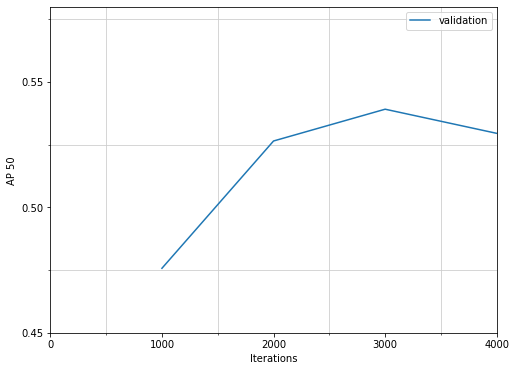

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.45, 0.58)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("AP 50")

mdf3 = mdf[~mdf["bbox/AP50"].isna()]
plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/AP50.png")

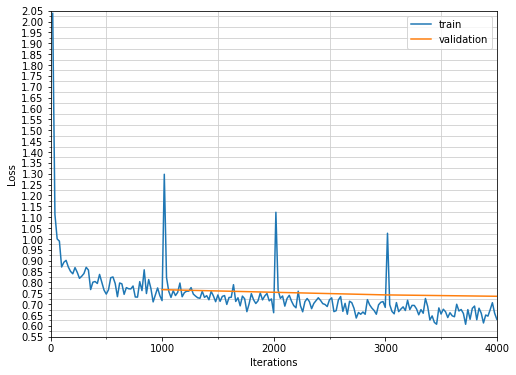

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.55, 2.05)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")

# plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')

mdf1 = mdf[~mdf["total_loss"].isna()]
plt.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    plt.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/loss.png")